<a href="https://colab.research.google.com/github/Thienbuu/practice_dl_project/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai2 -qq

     |████████████████████████████████| 194kB 8.1MB/s 


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!rm -rf data/train
!rm -rf data/test
!mkdir -p data/train
!mkdir -p data/test

In [4]:
!kaggle competitions download -c digit-recognizer -p data

  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 87.9MB/s]
 55% 5.00M/9.16M [00:00<00:00, 14.8MB/s]
100% 9.16M/9.16M [00:00<00:00, 23.2MB/s]
 82% 5.00M/6.09M [00:00<00:00, 21.5MB/s]
100% 6.09M/6.09M [00:00<00:00, 24.2MB/s]


In [5]:
!unzip data/test.csv.zip
!unzip data/train.csv.zip

Archive:  data/test.csv.zip
  inflating: test.csv                
Archive:  data/train.csv.zip
  inflating: train.csv               


In [6]:
from fastai2.vision.all import *
import pandas as pd

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (42000, 785)
test shape: (28000, 784)


In [9]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
cols = test.columns
def pixel2image(row, index, path_name):
  pixels =  row[cols].to_numpy(dtype=np.uint8)
  pixels = pixels.reshape(28, 28)
  img = Image.fromarray(pixels)
  img_path = 'data/{0}/{1}.png'.format(path_name, index)
  img.convert('RGB').save(img_path)
  return img_path


In [11]:
fname = []
for idx, row in train.iterrows():
  fname.append(pixel2image(row, idx, 'train'))

In [12]:
fname_series = pd.Series(data=fname, name='fname')
train_df = pd.concat([train['label'], fname_series], axis=1)
train_df = train_df.sort_values(by=['label'])
train_df.head()

,label,fname
9747,0,data/train/9747.png
4103,0,data/train/4103.png
27801,0,data/train/27801.png
27799,0,data/train/27799.png
37354,0,data/train/37354.png


In [13]:
labels = train_df['label'].unique().tolist()
valid = []
for label in labels:
   label_len = len(train_df[train_df['label'] == label])
   valid_len = int(label_len * 0.1)
   label_valid = np.concatenate([np.zeros(valid_len, dtype=bool),
                                  np.ones(label_len - valid_len, dtype=bool)])
   np.random.shuffle(label_valid)
   valid += list(label_valid)

train_df['valid']  = valid

In [14]:
for label in labels:
  label_df = train_df[train_df['label'] == label]
  print('label: {0}, train: {1}, valid {2}'.format( 
        label,
        label_df[label_df['valid'] == True].shape[0],
        label_df[label_df['valid'] == False].shape[0]))

label: 0, train: 3719, valid 413
label: 1, train: 4216, valid 468
label: 2, train: 3760, valid 417
label: 3, train: 3916, valid 435
label: 4, train: 3665, valid 407
label: 5, train: 3416, valid 379
label: 6, train: 3724, valid 413
label: 7, train: 3961, valid 440
label: 8, train: 3657, valid 406
label: 9, train: 3770, valid 418


In [15]:
fname = []
for idx, row in test.iterrows():
  fname.append(pixel2image(row, idx, 'test'))

In [16]:
fname_series = pd.Series(data=fname, name='fname')
test_df = pd.concat([test, fname_series], axis=1)
test_df = test_df[['fname']]
test_df.head()

,fname
0,data/test/0.png
1,data/test/1.png
2,data/test/2.png
3,data/test/3.png
4,data/test/4.png


In [17]:
path = Path('')

In [18]:
(path/'data/train').ls()

(#42000) [Path('data/train/24485.png'),Path('data/train/36501.png'),Path('data/train/4450.png'),Path('data/train/14655.png'),Path('data/train/36135.png'),Path('data/train/677.png'),Path('data/train/31694.png'),Path('data/train/18017.png'),Path('data/train/12722.png'),Path('data/train/1745.png')...]

In [32]:
np.random.seed(42)
def get_x(r): return Path(r['fname'])
def get_y(r): return str(r['label'])
def splitter(df): 
  train = df.index[~df['valid']].tolist()
  valid = df.index[df['valid']].tolist()
  return train, valid

def get_dls(bs, item_tfms_size, batch_tfms_size):
  dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                     splitter=splitter, get_x=get_x, get_y=get_y,
                     batch_tfms = aug_transforms(size=batch_tfms_size, 
                                                 min_scale=0.65, 
                                                 do_flip=False, 
                                                 max_rotate=20, 
                                                 max_zoom=1.2, 
                                                #  max_lighting=0.1, 
                                                #  p_affine=0.65,
                                                #  max_warp=0.3,
                                                #  mult=1.1
                                                 )
                     )
  return dblock.dataloaders(train_df)

In [33]:
dls = get_dls(64, 128, 50)

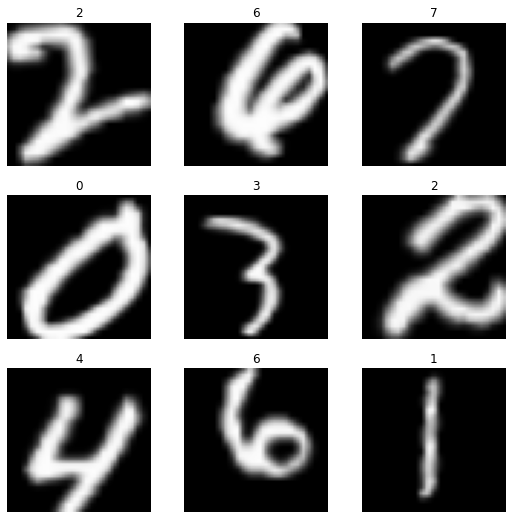

In [34]:
dls.show_batch(nrows=3, ncols=3)

In [53]:
learn = cnn_learner(dls, resnet50, 
                    loss_func=F.binary_cross_entropy_with_logits, 
                    metrics=accuracy_multi)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.033113110810518265)

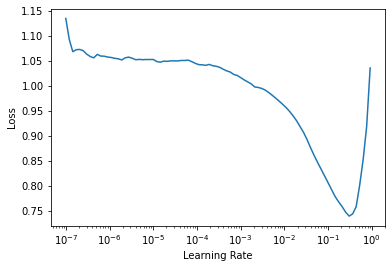

In [54]:
learn.lr_find()

In [55]:
learn.fine_tune(30, 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.506583,0.181158,0.933399,01:02


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.084941,0.026061,0.991511,01:03
1,0.045427,0.020128,0.993620,01:03
2,0.034583,0.015768,0.994803,01:02
3,0.030999,0.018939,0.993928,01:03
4,0.031657,0.017309,0.994763,01:02
5,0.031550,0.020190,0.993514,01:02
6,0.026751,0.014921,0.995451,01:02
7,0.027873,0.017989,0.994681,01:02
8,0.025258,0.016702,0.994982,01:02
9,0.020902,0.014197,0.995748,01:02


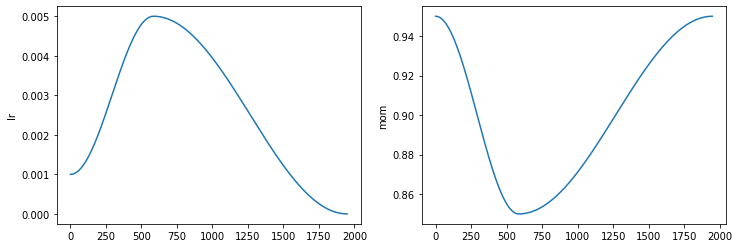

In [56]:
learn.recorder.plot_sched()

In [30]:
# base_lr = 4e-2
learn.fine_tune(30, lr=slice(4e-2, 0.5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.806955,0.548769,0.727727,01:37


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.515980,0.378074,0.877838,01:39
1,0.411453,0.246479,0.944921,01:41
2,0.293869,0.151333,0.966880,01:40
3,0.189213,0.078901,0.984137,01:40
4,0.116475,0.038468,0.991697,01:52
5,0.075937,0.028363,0.992231,01:47
6,0.053415,0.018961,0.994651,01:41
7,0.040596,0.017888,0.994344,01:40
8,0.032885,0.017975,0.994366,01:42
9,0.029115,0.016704,0.994869,01:39


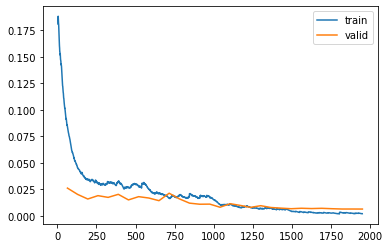

In [57]:
learn.recorder.plot_loss()

In [58]:
test_img = get_image_files('data/test')

In [59]:
test_dl = learn.dls.test_dl(test_img)

In [60]:
preds, targets = learn.tta(dl=test_dl)
print(preds[0].tolist())

preds_1, targets_1 = learn.get_preds(dl=test_dl)
print(preds_1[0].tolist())

[-18.479541778564453, -15.432415008544922, -18.757518768310547, -17.1927433013916, -17.240549087524414, -17.830224990844727, 14.76900863647461, -21.942325592041016, -16.76955223083496, -18.12575912475586]


[-15.446409225463867, -14.032710075378418, -16.256427764892578, -14.515692710876465, -13.99758529663086, -15.288810729980469, 12.034985542297363, -18.604652404785156, -14.196638107299805, -15.62325668334961]


In [61]:
class_score = np.argmax(preds, axis=1)

In [62]:
image_ids = [img.stem for img in test_img]

In [63]:
submission = pd.DataFrame(columns=['ImageId', 'Label'])

submission['ImageId'] = image_ids
submission['Label'] = class_score

submission['ImageId'] = submission['ImageId'].astype('int')
submission = submission.sort_values(by=['ImageId'])
submission['ImageId'] += 1

submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28000 entries, 15266 to 23821
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ImageId  28000 non-null  int64
 1   Label    28000 non-null  int64
dtypes: int64(2)
memory usage: 656.2 KB


In [64]:
submission.head()

,ImageId,Label
15266,1,2
19351,2,0
8565,3,9
18889,4,0
6720,5,3


In [65]:
submission.to_csv('third_submission.csv', index=False)

In [66]:
!kaggle competitions submit -c digit-recognizer -f third_submission.csv -m "second submission"

100% 208k/208k [00:02<00:00, 72.9kB/s]
Successfully submitted to Digit Recognizer